In [5]:
import pandas as pd
import numpy as np
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, KFold

from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [31]:
# make q22c_rec the target

df = pd.read_csv('data2.csv', sep=";")

# Define features (X) and target (y)
X = df.drop(columns=['TSC_682', 'q22c_rec', 'b2_rec'])
y = df['q22c_rec']
y = y - y.min()

# Split data into training+validation and test sets
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

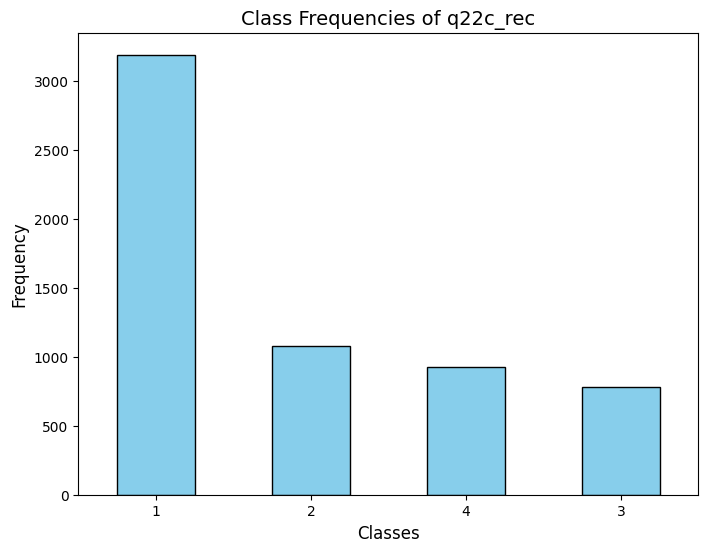

In [43]:
# Show the distribution of target classes
# as one sees, it is an imbalanced variable therefore weighted or balanced values need to be calculated
class_counts = df['q22c_rec'].value_counts()

class_counts.plot(kind='bar', figsize=(8, 6), color='skyblue', edgecolor='black')

plt.title('Class frequencies of q22c_rec', fontsize=14)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=0)
plt.show()


In [53]:
# chose a bunch of different models from sklearn to try out and find the most promising algorithm for this dataset
# use the entire dataset for this initial identification of the most promising algorithm

sgd_model = SGDClassifier()
kn_model = KNeighborsClassifier()
gaussian_model = GaussianProcessClassifier(random_state=12)
decTree_model = DecisionTreeClassifier(random_state=12)
randForest_model = RandomForestClassifier(random_state=12)
ada_model = AdaBoostClassifier(algorithm='SAMME', random_state=12)
gradBoost_model = GradientBoostingClassifier(random_state=12)

models = {'SGD':sgd_model, 'KNN':kn_model, 'DECISION TREE':decTree_model,
          'RANDOM FOREST':randForest_model, 'ADABOOST':ada_model, 'GBM':gradBoost_model}

# Cross-validate each model and calculate weighted accuracy (balanced accuracy)
for name, model in models.items():
    cv = KFold(n_splits=5)
    # Use 'balanced_accuracy' scoring
    score = cross_validate(model, X, y.astype(int), scoring='balanced_accuracy', cv=cv, return_train_score=False)
    print(name, score['test_score'])  # Scores for each fold
    print("Average weighted/balanced accuracy score", np.round(np.mean(score['test_score']), 3))
    print('\n')

SGD [0.31640942 0.3255222  0.32601989 0.27635965 0.36476952]
Average weighted/balanced accuracy score 0.322


KNN [0.37273891 0.35168649 0.34588079 0.34120802 0.33492217]
Average weighted/balanced accuracy score 0.349


DECISION TREE [0.31104229 0.3697312  0.31187678 0.31808459 0.29519919]
Average weighted/balanced accuracy score 0.321


RANDOM FOREST [0.42345185 0.40122218 0.36931924 0.36980387 0.33269188]
Average weighted/balanced accuracy score 0.379


ADABOOST [0.39003119 0.41210631 0.38167135 0.37051956 0.37241344]
Average weighted/balanced accuracy score 0.385


GBM [0.45424791 0.41498706 0.38676758 0.37510074 0.34574588]
Average weighted/balanced accuracy score 0.395




To idenitfy the most promising algorithms, we used weighted/balanced accuracy as the goodness-of-fit metric, because the target was quite imbalanced i.e. classes were of different size.


GradientBoostingClassifier returned the best goodness-of-fit value.

So we continue tuning GradientBoostingClassifier hyperparameters

GB builds trees sequentially, minimizing the difference between predictions and true values at each step, i.e. it focuses on gradual improvement. Therfore  it is suitable for identifying weak patterns and weak relationships in the data. This is exaclty the case with opinion survey data. It also handles imbalanced data well, which too is the case with this dataset.


In [34]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html

#class sklearn.ensemble.GradientBoostingClassifier(*, loss='log_loss',
# learning_rate=0.1,
# n_estimators=100,
# subsample=1.0,
# criterion='friedman_mse',
# min_samples_split=2,
# min_samples_leaf=1,
# min_weight_fraction_leaf=0.0,
# max_depth=3,
# min_impurity_decrease=0.0,
# init=None,
# random_state=None,
# max_features=None,
# verbose=0,
# max_leaf_nodes=None,
# warm_start=False,
# validation_fraction=0.1,
# n_iter_no_change=None,
# tol=0.0001,
# ccp_alpha=0.0)

# Here we define the search space for XGBoost hyperparameters, using not search grid but picking concrete values from a range of values of each hyperparameter. Using the uniform distribution implies that at each iteration, each value withing the range of the values has an equal likelihood to be selected or picked for testing a concrete hyperparameter configuration. Typical ranges are used.

search_space = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 300, 25)),
    'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'reg_lambda': hp.loguniform('reg_lambda', np.log(1e-3), np.log(10)),
    'reg_alpha': hp.loguniform('reg_alpha', np.log(1e-3), np.log(10)),
    'min_child_weight': scope.int(hp.quniform('min_child_weight', 1, 10, 1))
}

In [35]:
# Define the objective function to optimize weighted accuracy
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-early-stopping-py

def objective(params):
    model = XGBClassifier(
        learning_rate=params['learning_rate'],
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        min_child_weight=int(params['min_child_weight']),
        use_label_encoder=False,
        random_state=42
    )
        # perform 5-fold cross-validation
        # use only the training-validation dataset, not the entire dataset
    scores = cross_val_score(
        model, X_train_valid, y_train_valid, cv=5,
        scoring='balanced_accuracy', n_jobs=-1
    )

    # maximize balanced accuracy, taking into account that Hyperopt minimizes the loss
    loss = 1 - scores.mean()
    return {'loss': loss, 'status': STATUS_OK}

In [47]:
# Run Hyperopt to find the best hyperparameters
trials = Trials()
best = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest, # Tree-Structured Parzen Estimator, that uses Bayesian optimisation for picking hyperparater values in the vicinity of the values that have proved promising in terms of minimising the goodness of fit metric.
    max_evals=1500, # this parameter determines the number of hyperparameter configurations tested (unless early stopping is used, which was not the case). At each iteration, a value within the range specified in the search space is picked and used. 1500 was used because tests with several values showed that for this dataset and algo, approximately 1000 should be enough i.e. loss does not improve any more
    trials=trials,
    rstate=np.random.default_rng(42)
)

100%|██████████| 1500/1500 [1:30:00<00:00,  3.60s/trial, best loss: 0.5734924293656423]


In [48]:
# Map the best hyperparameters
best_params = {
    'learning_rate': best['learning_rate'],
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'reg_lambda': best['reg_lambda'],
    'reg_alpha': best['reg_alpha'],
    'min_child_weight': int(best['min_child_weight'])
}

print("Best hyperparameters found: ", best_params)

Best hyperparameters found:  {'learning_rate': 0.1537636448142757, 'n_estimators': 300, 'max_depth': 9, 'subsample': 0.6485550590964768, 'colsample_bytree': 0.9267572840771351, 'reg_lambda': 2.5692967214517273, 'reg_alpha': 9.91597513652389, 'min_child_weight': 9}


In [49]:
# Train the final model using the best hyperparameters
final_model = XGBClassifier(
    **best_params,
    use_label_encoder=False,
    objective = 'multi:softmax',
    random_state=42
)
final_model.fit(X_train_valid, y_train_valid)

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [16:40:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9267572840771351, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1537636448142757,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=9, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [50]:
# Evaluate the final model on the test set
y_test_pred = final_model.predict(X_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)

print(f"\nFinal Balanced Accuracy on Test Set: {balanced_accuracy:.4f}")


Final Balanced Accuracy on Test Set: 0.4275


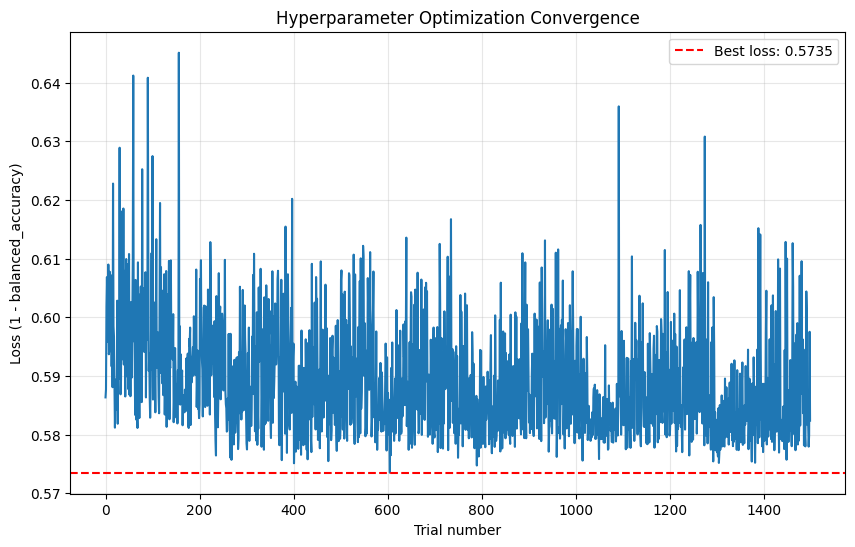

Best loss: 0.5735
Best balanced accuracy: 0.4265
Trial number that found best loss: 605


In [51]:
import matplotlib.pyplot as plt
# checking if 1500 iterations was enough
# 1500 looks good because the best value, or a value very close to the best value, was found early, already at approx iteration 800 and it did not imrove until 2500 - so probably there won't be any major improvement when the number of iterations will be increased

# get loss values from trials
losses = [t['result']['loss'] for t in trials.trials]

plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.xlabel('Trial number')
plt.ylabel('Loss (1 - balanced_accuracy)')
plt.title('Hyperparameter Optimization Convergence')

#  add best score line
plt.axhline(y=min(losses), color='r', linestyle='--', label=f'Best loss: {min(losses):.4f}')
plt.legend()

plt.grid(True, alpha=0.3)
plt.show()

print(f"Best loss: {min(losses):.4f}")
print(f"Best balanced accuracy: {1 - min(losses):.4f}")
print(f"Trial number that found best loss: {losses.index(min(losses))}")

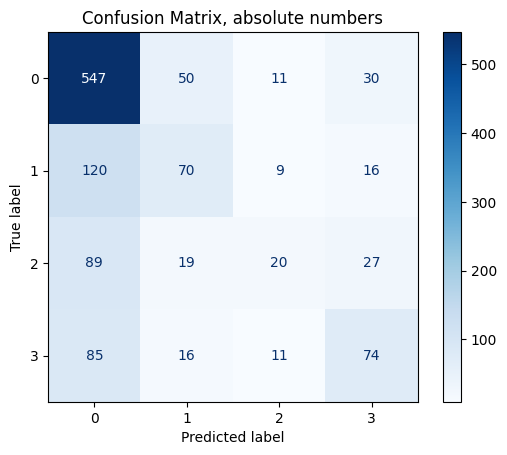

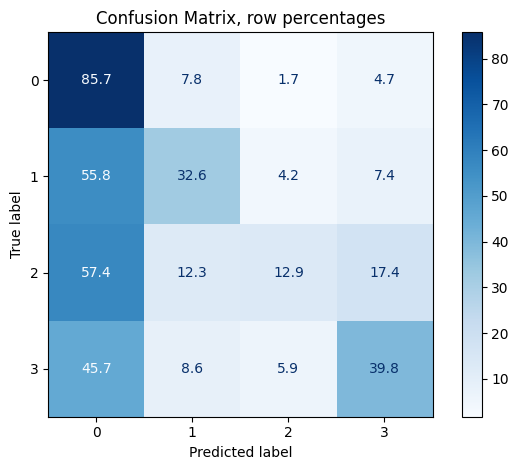

Precision, weighted: 0.5582
Recall, weighted: 0.5955
F1-Score, weighted: 0.5578


In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt

#  confusion matrix
cm = confusion_matrix(y_test, y_test_pred) # absolute numbers
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100 # percentages

#  confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap='Blues')
plt.title("Confusion Matrix, absolute numbers")
plt.show()

#  confusion matrix using percentages
disp = ConfusionMatrixDisplay(confusion_matrix=cm_percentage, display_labels=np.unique(y))
disp.plot(cmap='Blues', values_format='.1f')
plt.title("Confusion Matrix, row percentages")

plt.tight_layout()
plt.show()

precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Precision, weighted: {precision:.4f}")
print(f"Recall, weighted: {recall:.4f}")
print(f"F1-Score, weighted: {f1:.4f}")

